# MDI+: Example Usages

In [85]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [86]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [87]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [88]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [89]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.5087928271560848

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [90]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "loo",
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.808563  0.742251  0.132783  0.181474  0.181893  0.316807  0.281593   
1    0.825210  0.606816  0.264283  0.224878  0.242270  0.415012  0.160558   
2    0.821360  0.704462  0.252986  0.265737  0.360919  0.332896  0.168214   
3    0.839437  0.754327  0.225580  0.278614  0.406064  0.259067  0.242453   
4    0.728986  0.698632  0.206453  0.390143  0.314231  0.284695  0.160759   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.725829  0.719688  0.234946  0.234000  0.215127  0.294265  0.247878   
130  0.708931  0.679197  0.142435  0.327792  0.245954  0.276193  0.419852   
131  0.858804  0.865340  0.201559  0.270493  0.385014  0.245572  0.237238   
132  0.712082  0.732328  0.178008  0.508046  0.242898  0.283720  0.248153   
133  0.867731  0.771912  0.142755  0.199026  0.201

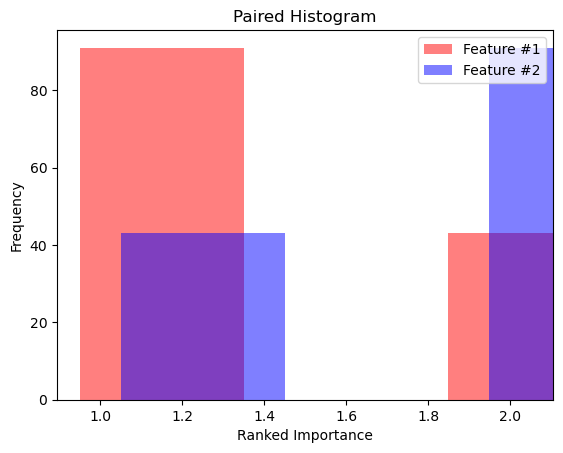

In [91]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [92]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "loo",
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.763300  0.711860  0.117298  0.171820  0.155087  0.309545  0.271249   
1    0.792172  0.522004  0.241939  0.218801  0.218090  0.409169  0.126442   
2    0.800971  0.625306  0.238854  0.254981  0.348520  0.324575  0.151247   
3    0.692810  0.488232  0.202602  0.243156  0.398834  0.244499  0.215779   
4    0.611084  0.613041  0.201760  0.379473  0.306660  0.282128  0.136976   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.569359  0.583065  0.226707  0.199765  0.192612  0.290883  0.229836   
130  0.523346  0.543079  0.107888  0.316802  0.206154  0.271675  0.414540   
131  0.800059  0.744541  0.198260  0.252163  0.377238  0.215115  0.220913   
132  0.541570  0.607146  0.154068  0.503340  0.186172  0.280641  0.231531   
133  0.841329  0.745257  0.129232  0.163576  0.195

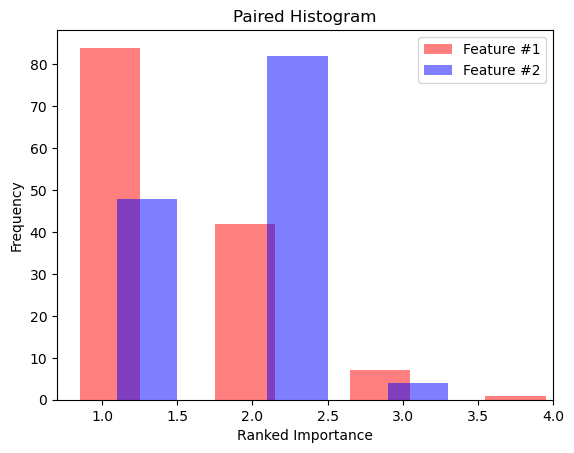

In [93]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Standard Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{j}*\Psi^{(k)}_{i,j}|$

In [94]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "standard",
                                                    lfi_abs = "inside")

Local MDI+ w/ Standard Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.809262  0.744338  0.132421  0.181517  0.182754  0.312618  0.280488   
1    0.857848  0.612027  0.270204  0.227229  0.245144  0.425400  0.164827   
2    0.821116  0.705740  0.252442  0.265472  0.360365  0.332768  0.168445   
3    0.837211  0.752724  0.225684  0.278130  0.405676  0.259178  0.242206   
4    0.727300  0.698486  0.205778  0.389745  0.313434  0.283982  0.160354   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.731188  0.720793  0.236912  0.234014  0.215530  0.299106  0.248981   
130  0.707468  0.678312  0.142232  0.326896  0.245697  0.275846  0.419234   
131  0.858107  0.865507  0.201094  0.270499  0.384818  0.244543  0.236414   
132  0.705334  0.729768  0.177418  0.506285  0.241959  0.283008  0.247869   
133  0.910796  0.785576  0.145438  0.203604  0.205659  

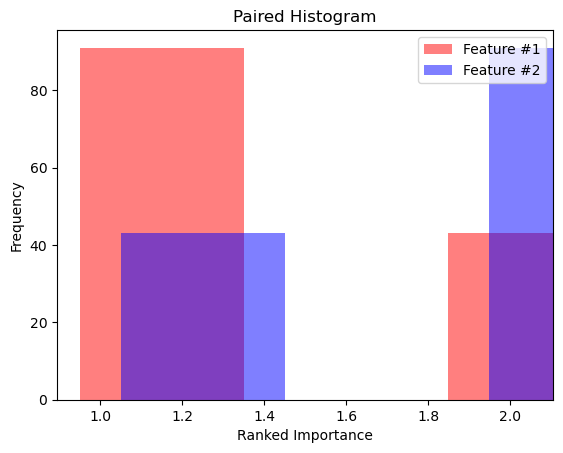

In [95]:
print("Local MDI+ w/ Standard Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_standard_inside = mdi_plus_scores["lfi"]
print(lfi_standard_inside)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_standard_inside.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Standard Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{j}*\Psi^{(k)}_{i,j}|$

In [96]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "standard",
                                                    lfi_abs = "outside")

Local MDI+ w/ Standard Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.763991  0.714076  0.116958  0.172016  0.155922  0.305404  0.270171   
1    0.826257  0.526128  0.246763  0.221075  0.220550  0.419510  0.129059   
2    0.800728  0.626430  0.238643  0.254744  0.347970  0.324482  0.151135   
3    0.690775  0.486778  0.202676  0.242673  0.398441  0.244648  0.215563   
4    0.608894  0.613018  0.201082  0.379064  0.305906  0.281417  0.136680   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.578186  0.584110  0.228733  0.199770  0.193085  0.295715  0.230963   
130  0.521299  0.542645  0.107472  0.315907  0.206038  0.271340  0.413924   
131  0.799134  0.744298  0.197810  0.252161  0.377089  0.214030  0.219888   
132  0.531109  0.604661  0.153364  0.501581  0.185837  0.279917  0.231270   
133  0.884407  0.759660  0.131824  0.168094  0.199661  

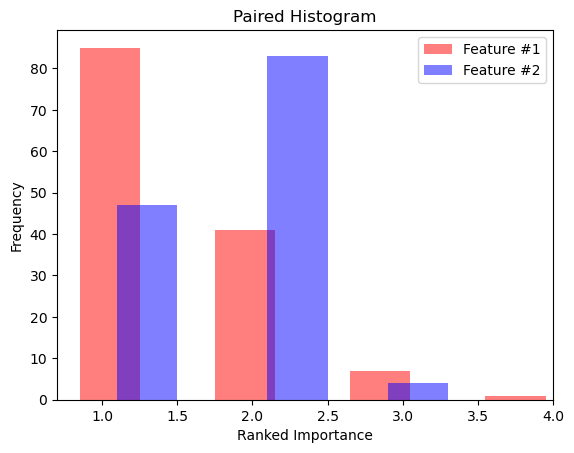

In [97]:
print("Local MDI+ w/ Standard Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_standard_inside = mdi_plus_scores["lfi"]
print(lfi_standard_inside)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_standard_inside.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()